In [3]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
sys.path.append("../")
from functions.spike_detection import detect_spikes, merge_spike_indices, get_waveforms
from functions.feature_extraction import pca_feature_extraction

In [5]:
Fs = 30000     # sampling rate of the signal in Hz
SAMPLE_RATE = 30000     # sampling rate of the signal in Hz
DT = 1 / SAMPLE_RATE
T = 100000
dt = 1/Fs
gain = .5  
PRIMARY_COLOUR = "black"

In [6]:
df = pd.read_csv("../../tubingen_exersizes/data/filtered_signal.csv")
df.head()

,Unnamed: 0,Ch1,Ch2,Ch3,Ch4
0,0,-3.324364e-10,-4.226478e-10,7.466865e-10,-1.857514e-09
1,1,-1.656188e+00,1.618690e+00,5.753624e+00,-4.373628e+00
2,2,-6.687551e+00,2.324345e+00,7.815885e+00,-8.476717e+00
3,3,-1.678361e+01,1.246341e+00,4.150506e+00,-1.287599e+01
4,4,-3.098116e+01,-2.249123e+00,-4.835007e+00,-1.877361e+01


In [7]:
y = df['Ch1'].values

channels = ["Ch1", "Ch2", "Ch3", "Ch4"]
data = df[channels].values

We can plot the four channels of filtered data

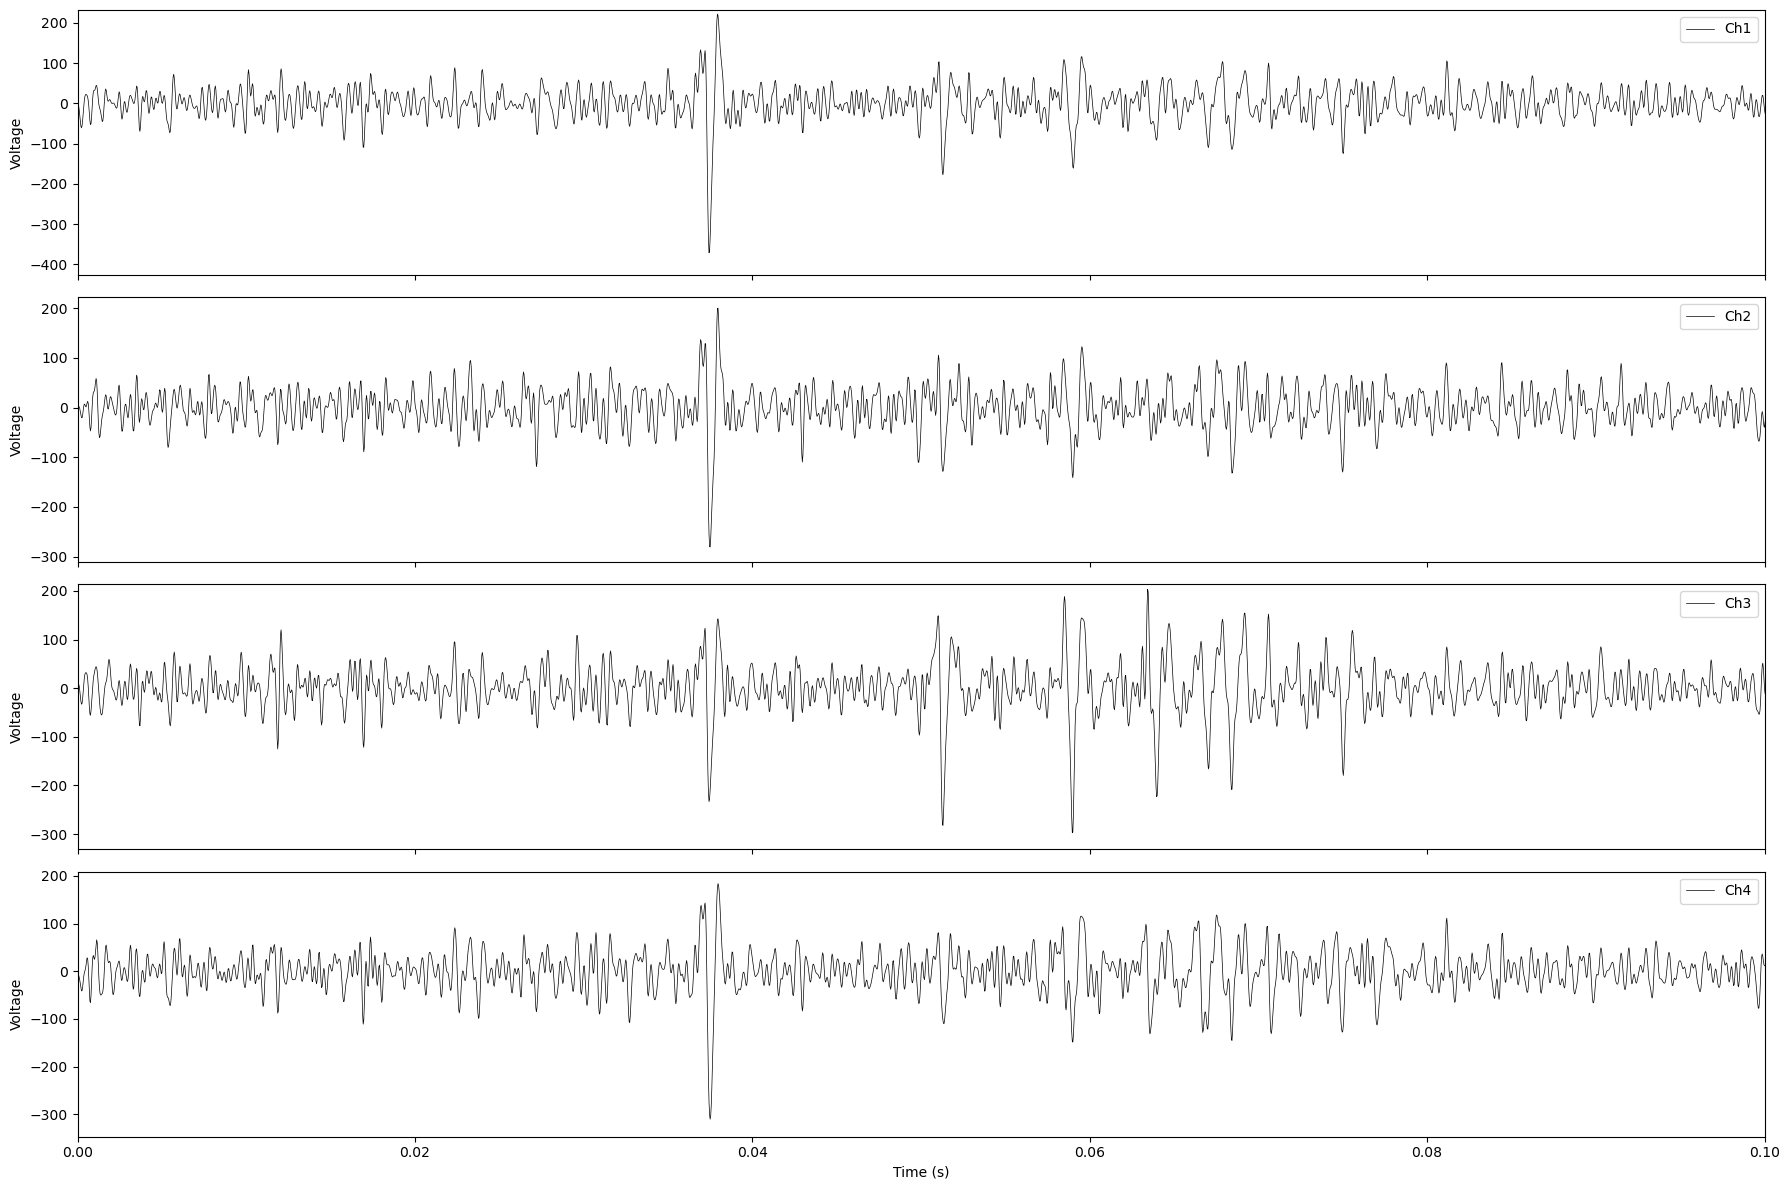

In [8]:
# create a time array for the x axis
time = np.arange(0, T) * DT

fig, axs = plt.subplots(len(channels), sharex=True, figsize=(18, 3*len(channels)))

# plot each channel
for i, ax in enumerate(axs):
    ax.plot(time[0:T], data[0:T, i], label=channels[i], lw=0.5, c="k")
    ax.set_ylabel('Voltage')
    ax.legend()  # show a legend for each subplot
    ax.set_ylim((min(data[0:T, i]) - 10, max(data[0:T, i]) + 10))

axs[-1].set_xlabel('Time (s)')  # only set x-label for the last subplot
plt.xlim(0, 0.1)
plt.tight_layout()
plt.show()

In [20]:
# set a threshold mulitplier -> heuristic
threshold_factor = -5

# initialize spikes as an empty list
spikes = []

print(data.shape)

# loop through each of the channels
for i in range(data.shape[1]):

    # calculate robust s.d. using the mean absolute deviation (MAD)
    sigma = np.median(np.abs(data[:, i] - np.median(data[:, i])) / 0.6745)

    # set the threshold for this channel
    threshold = threshold_factor * sigma

    # detect spikes in this channel
    spikes_channel = detect_spikes(y=data[:, i], threshold=threshold, minimum_gap=1, use_absolute_threshold=True, flipped=True)

    # append the detected spikes to the list
    spikes.append(spikes_channel)

# convert spikes to a numpy array
spikes = np.array(spikes)

(756705, 4)
<class 'numpy.ndarray'>
(756705,)
<class 'numpy.ndarray'>
(756705,)
<class 'numpy.ndarray'>
(756705,)
<class 'numpy.ndarray'>
(756705,)


/var/folders/ct/68fpdtpx6lq75x8hr444s83h0000gn/T/ipykernel_3851/4286506659.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spikes = np.array(spikes)


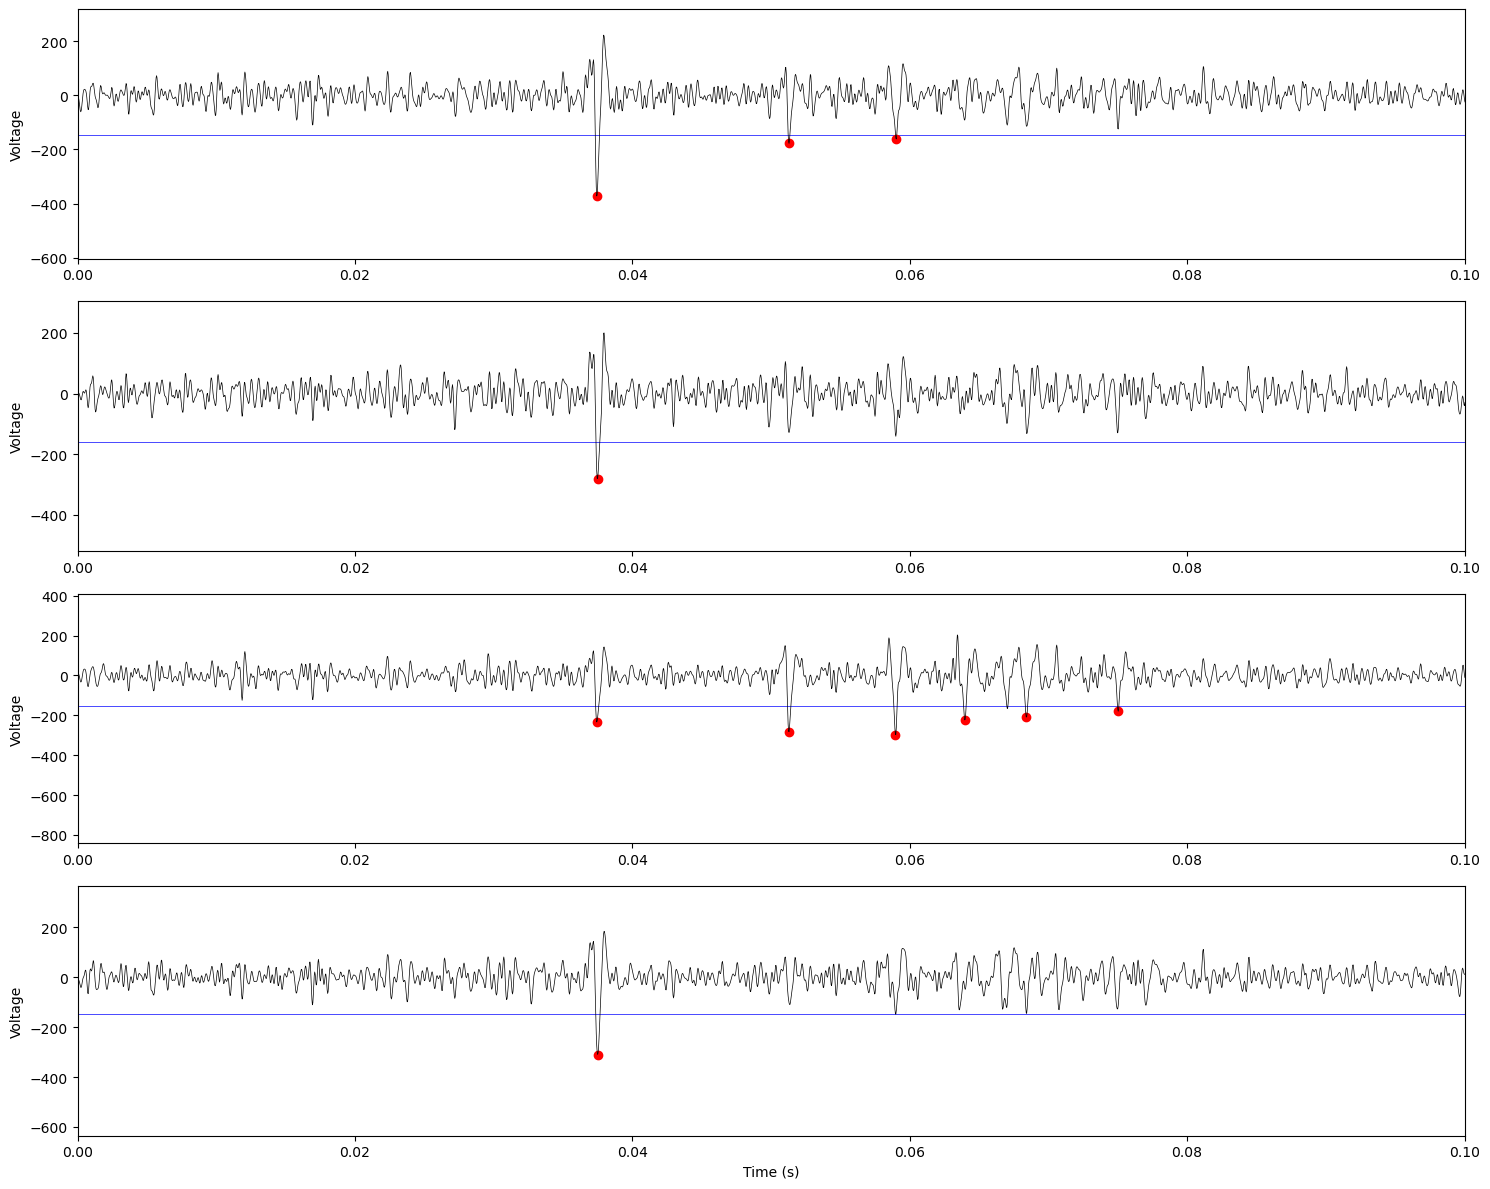

In [10]:
plt.figure(figsize=(15, 3 * data.shape[1]))

for i in range(data.shape[1]):
    plt.subplot(data.shape[1], 1, i+1)
    
    # Plot the signal for this channel
    plt.plot(time[0:T], data[0:T, i], linewidth=.5, c="k")
    
    # Plot the threshold for this channel
    sigma = np.median(np.abs(data[0:T, i] - np.median(data[:, i])) / 0.6745)
    threshold = threshold_factor * sigma
    plt.axhline(y=threshold, c="blue", linewidth=0.5, zorder=0)
    
    # Plot the spike locations for this channel
    plt.scatter(spikes[i] * DT, data[spikes[i], i], color='red')
    
    plt.ylim((min(data[:, i]) - 50, max(data[:, i]) + 50))
    plt.xlim(0, 0.1)
    plt.ylabel('Voltage')

plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

At the moment, each channel has a different number of spikes - only at the points where the theshold value is crossed. We need to identify the location on each signal where spikes on the other channels occur. This will result in an equal number of locations on each channel.

For example, the indicies for the locations of spikes on the first few channels looks like this: 

- [  1123,   1539,   1771,   5495,   6801,   7976 ... ]
- [  1125,   1770,   6801,   7977,  18533,  24351 ... ]

We can see that some of the spikes are really close together. `Assumption` we are going to assume that these spikes occur at exactly the same time, so in this case the midpoint will be taken (or rounded to nearest integer). After the function, these arrays should look like this:

- [  1124,   1539,   1771,   5495,   6801,   7971,  18533,  24351 ... ]
- [  1124,   1539,   1771,   5495,   6801,   7977,  18533,  24351 ... ]

So, we should really only need a singular output array that looks like: [  1125,   1539,   1770, ... ]

In [11]:
merged_spike_indices = merge_spike_indices(spikes, tolerance=2)

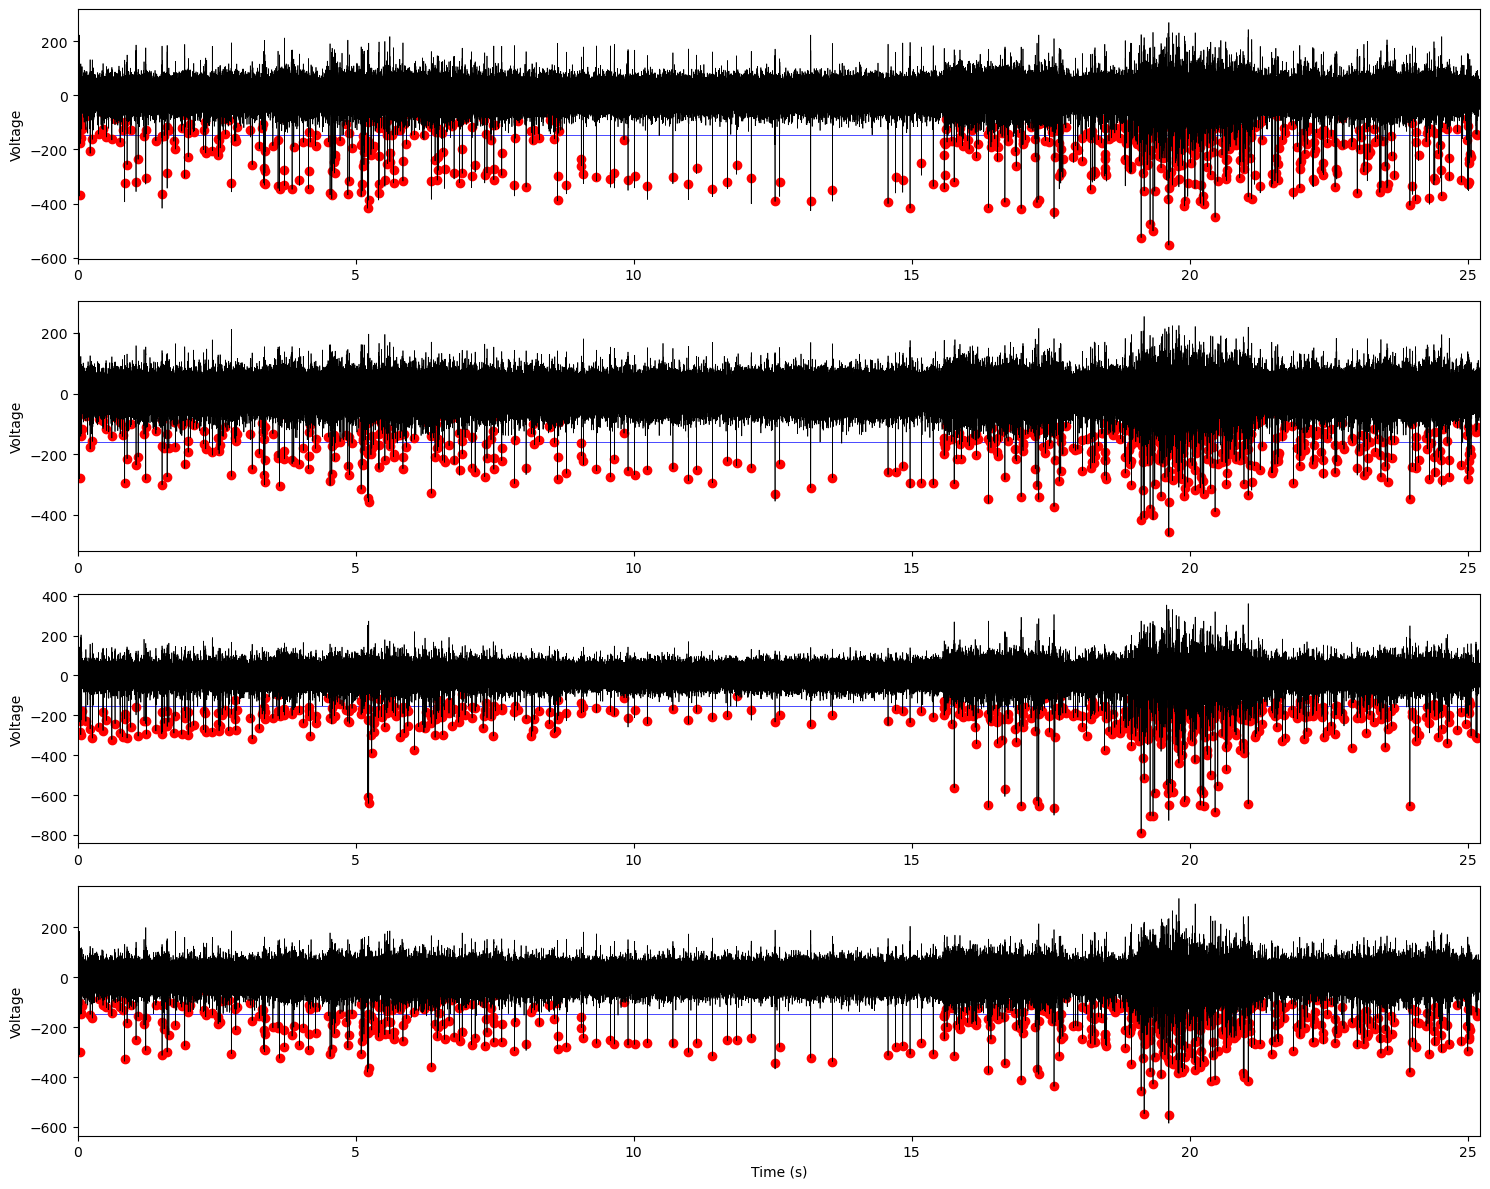

In [12]:
plt.figure(figsize=(15, 3 * data.shape[1]))

tt = np.arange(0, len(data[:, 1])) * DT

for i in range(data.shape[1]):
    plt.subplot(data.shape[1], 1, i+1)
    
    # Plot the signal for this channel
    plt.plot(tt, data[:, i], linewidth=.5, c="k")
    
    # Plot the threshold for this channel
    sigma = np.median(np.abs(data[0:T, i] - np.median(data[:, i])) / 0.6745)
    threshold = threshold_factor * sigma
    plt.axhline(y=threshold, c="blue", linewidth=0.5, zorder=0)
    
    # Plot the spike locations for this channel
    plt.scatter(merged_spike_indices * DT, data[merged_spike_indices, i], color='red')
    
    plt.ylim((min(data[:, i]) - 50, max(data[:, i]) + 50))
    plt.xlim(0, max(tt))
    plt.ylabel('Voltage')

plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

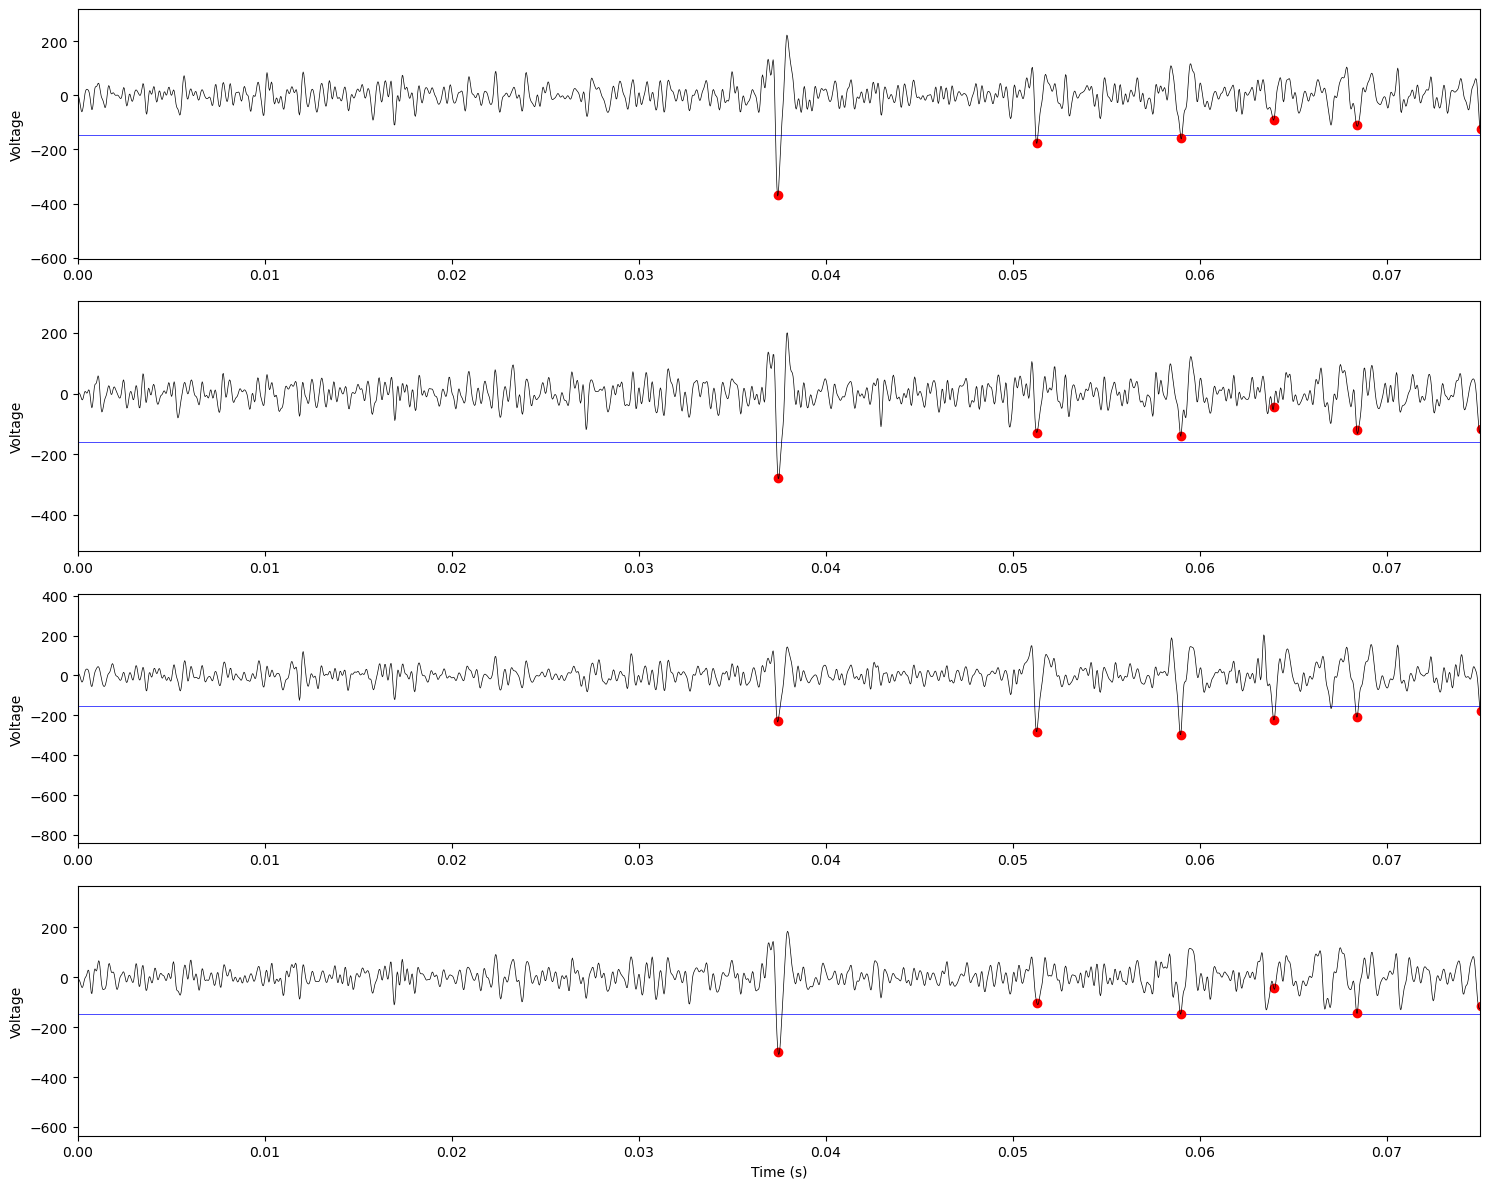

In [13]:
plt.figure(figsize=(15, 3 * data.shape[1]))

for i in range(data.shape[1]):
    plt.subplot(data.shape[1], 1, i+1)
    
    # Plot the signal for this channel
    plt.plot(time[0:T], data[0:T, i], linewidth=.5, c="k")
    
    # Plot the threshold for this channel
    sigma = np.median(np.abs(data[0:T, i] - np.median(data[:, i])) / 0.6745)
    threshold = threshold_factor * sigma
    plt.axhline(y=threshold, c="blue", linewidth=0.5, zorder=0)
    
    # Plot the spike locations for this channel
    plt.scatter(merged_spike_indices * DT, data[merged_spike_indices, i], color='red')
    
    plt.ylim((min(data[:, i]) - 50, max(data[:, i]) + 50))
    plt.xlim(0, 0.075)
    plt.ylabel('Voltage')

plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

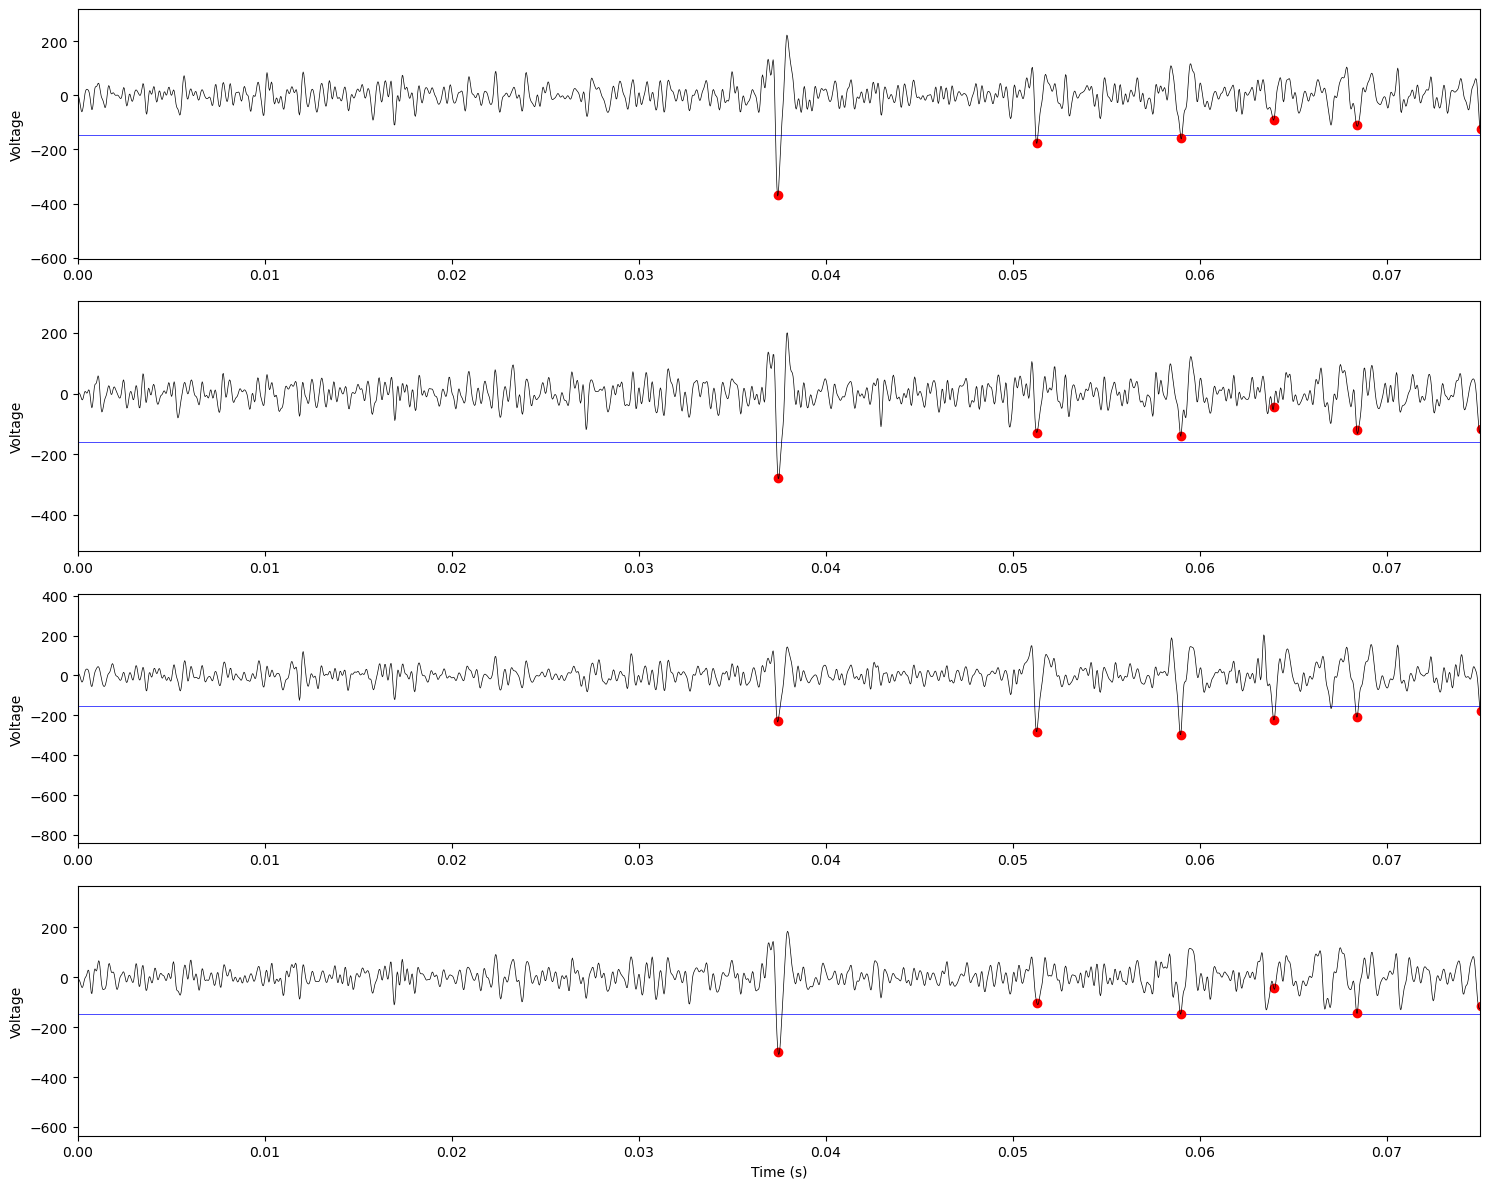

In [14]:
plt.figure(figsize=(15, 3 * data.shape[1]))

for i in range(data.shape[1]):
    plt.subplot(data.shape[1], 1, i+1)
    
    # Plot the signal for this channel
    plt.plot(time[0:T], data[0:T, i], linewidth=.5, c="k")
    
    # Plot the threshold for this channel
    sigma = np.median(np.abs(data[0:T, i] - np.median(data[:, i])) / 0.6745)
    threshold = threshold_factor * sigma
    plt.axhline(y=threshold, c="blue", linewidth=0.5, zorder=0)
    
    # Plot the spike locations for this channel
    plt.scatter(merged_spike_indices * DT, data[merged_spike_indices, i], color='red')
    
    plt.ylim((min(data[:, i]) - 50, max(data[:, i]) + 50))
    plt.xlim(0, 0.075)
    plt.ylabel('Voltage')

plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

In [15]:
waveforms = []
waveform_info = []

# loop through each of the channels
for i in range(data.shape[1]):
    # get waveforms for this channel
    waveforms_channel, waveform_info_channel = get_waveforms(y=data[:, i], spike_indices=merged_spike_indices, duration=1, sample_rate=SAMPLE_RATE, window_shift_ratio=1/3)
    
    # append the waveforms and waveform_info to the lists
    waveforms.append(waveforms_channel)
    waveform_info.append(waveform_info_channel)

# convert waveforms and waveform_info to numpy arrays
waveforms = np.array(waveforms)
waveform_info = np.array(waveform_info)

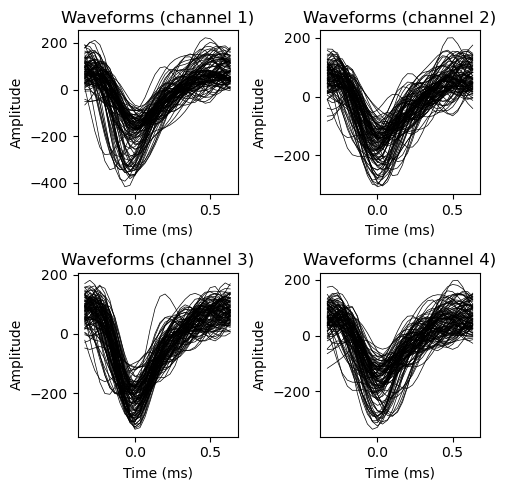

In [16]:
# determine the number of channels
n_channels = waveforms.shape[0]

# calculate the size of the grid
grid_size = int(np.sqrt(n_channels))

# create a figure and subplots
fig, axs = plt.subplots(grid_size, grid_size, figsize=(5, 5))

# make sure axs is always an array
if n_channels == 1:
    axs = np.array([[axs]])

# iterate over the channels
for i in range(grid_size):
    for j in range(grid_size):
        channel_idx = i * grid_size + j
        # iterate over the waveforms in this channel and plot each on top of each other
        for waveform in waveforms[channel_idx][:100]:
            t = np.arange(-10, 20) * DT * 1000 

            # plot the waveform
            axs[i, j].plot(t, waveform, c="black", lw=.5)

        axs[i, j].set_xlabel('Time (ms)')
        axs[i, j].set_ylabel('Amplitude')
        axs[i, j].set_title(f'Waveforms (channel {channel_idx+1})')

plt.tight_layout()
plt.show()

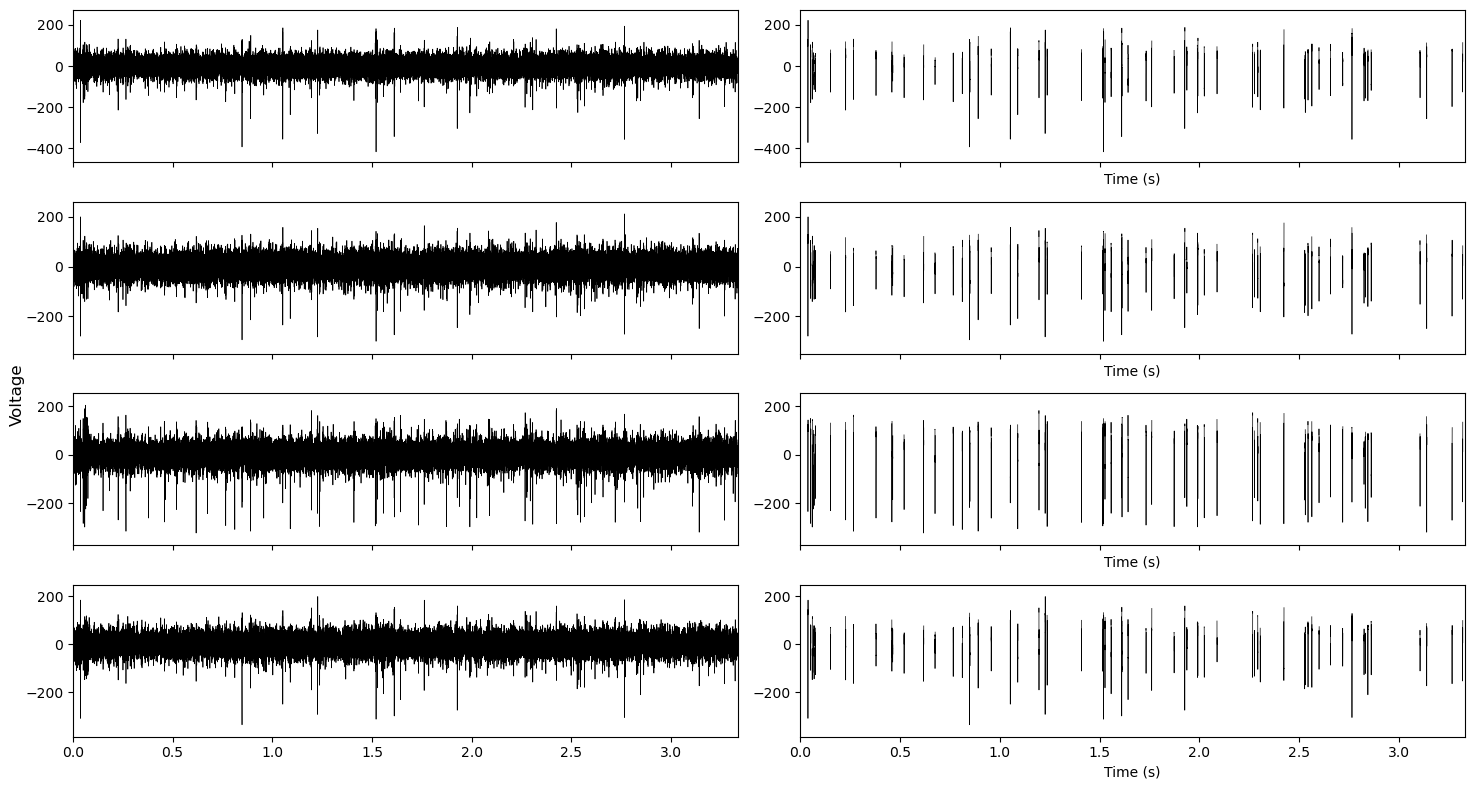

In [17]:
# determine the number of channels
n_channels = data.shape[1]

# create a figure and subplots
fig, axs = plt.subplots(n_channels, 2, figsize=(15, 2 * n_channels), sharex=True)

# make sure axs is always an array
if n_channels == 1:
    axs = np.array([[axs]])

# iterate over the channels
for i in range(n_channels):

    # plot the raw data for this channel
    axs[i, 0].plot(time[0:T], data[:T, i], label='Raw Data', c='k', lw=0.5)
    axs[i, 0].set_ylim((min(data[:T, i]) - 50, max(data[:T, i]) + 50))
    axs[i, 0].set_xlim((0, max(time)))
    
    # iterate through each spike and plot its waveform for this channel
    for spike in waveform_info[i]:
        spike_window = slice(spike["spike_start"], spike["spike_end"])
        axs[i, 1].plot(time[0:T][spike_window], data[:T, i][spike_window], c='k', lw=0.5)

    axs[i, 1].set_xlabel('Time (s)')
    axs[i, 1].set_ylim((min(data[:T, i]) - 50, max(data[:T, i]) + 50))
    axs[i, 1].set_xlim((0, max(time[0:T])))

fig.supylabel("Voltage")
plt.tight_layout()
plt.show()
